# Lens model DESIJ1018-0008

Author: Mamunur Rashid

# import of standard python libraries


In [85]:
import h5py
import matplotlib.pyplot as plt

# import of standard python libraries
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

### Extracting the observed image data from a .h5 file

In [86]:
with h5py.File("DESIJ1018-0008_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
# kwargs_data

### Extracting the information about Point Spread Function(PSF) from a .h5 file

In [87]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"
# kwargs_psf

# Visualizing the image

/tmp/ipykernel_6600/772600135.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')


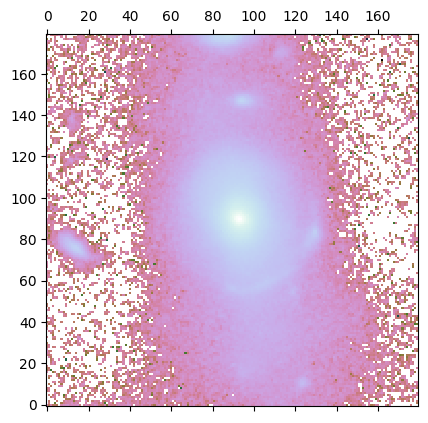

In [88]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
# plt.grid(which='both', color='black')
# plt.minorticks_on()
# plt.grid(which='minor', color='black')
plt.show()

# Masking

[[ 7.24  7.16  7.08 ... -6.92 -7.   -7.08]
 [ 7.24  7.16  7.08 ... -6.92 -7.   -7.08]
 [ 7.24  7.16  7.08 ... -6.92 -7.   -7.08]
 ...
 [ 7.24  7.16  7.08 ... -6.92 -7.   -7.08]
 [ 7.24  7.16  7.08 ... -6.92 -7.   -7.08]
 [ 7.24  7.16  7.08 ... -6.92 -7.   -7.08]] [[-7.24 -7.24 -7.24 ... -7.24 -7.24 -7.24]
 [-7.16 -7.16 -7.16 ... -7.16 -7.16 -7.16]
 [-7.08 -7.08 -7.08 ... -7.08 -7.08 -7.08]
 ...
 [ 6.92  6.92  6.92 ...  6.92  6.92  6.92]
 [ 7.    7.    7.   ...  7.    7.    7.  ]
 [ 7.08  7.08  7.08 ...  7.08  7.08  7.08]]


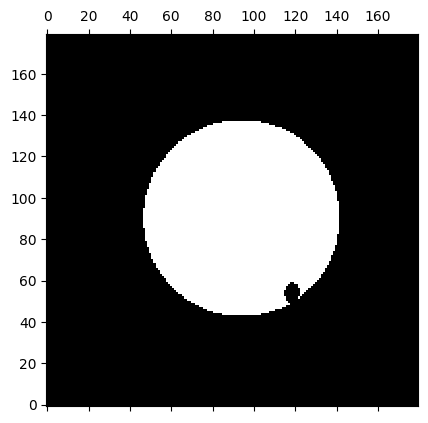

/tmp/ipykernel_6600/3400461388.py:73: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data),
/tmp/ipykernel_6600/3400461388.py:73: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data),


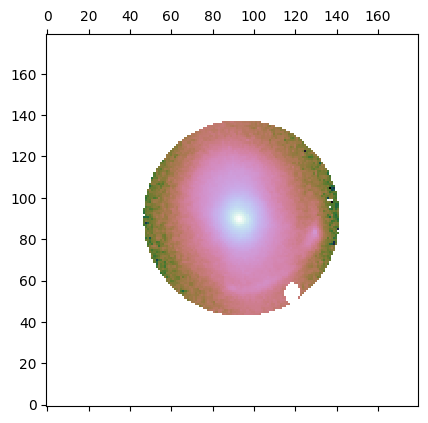

In [89]:
# To make a likelihood mask using lenstronomy functions,
# here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

print(x_coords, y_coords)

r = 3.8  # arcseconds
b = 5
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra - 0.3,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

"""mask_outer = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra,
    lens_center_dec,
    r,
    b,
    -1.1*np.pi / 2,
)"""


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec + 4.7,
    0.7,
    0.5,
    0,
)
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.4,
    lens_center_dec + 7,
    1.0,
    0.5,
    0,
)

mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.25,
    lens_center_dec - 2.9,
    0.3,
    0.4,
    0,
)


mask = (1 - mask_outer) * (1 - mask_ext_1) * (1 - mask_ext_2) * (1 - mask_ext_3)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# mask image data
masked_image_data = np.multiply(image_data, mask)

plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
# plt.grid(which='both', color='black')
# plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [90]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

### Mass model of the lens galaxy

In [91]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# EPL Profile

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 2.25,
        "gamma": 2,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.05,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2,
        "gamma": 0.05,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {"theta_E": 3, "gamma": 2.5, "e1": 0.5, "e2": 0.5, "center_x": 10, "center_y": 10}
)
# SHEAR Profile

fixed_lens.append({})
kwargs_lens_init.append({"gamma1": 0.0, "gamma2": 0.0, "ra_0": 0.0, "dec_0": 0.0})
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05, "ra_0": 0.5, "dec_0": 0.5})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -10, "dec_0": -10})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 10, "dec_0": 10})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

### Light model of the lens galaxy

In [92]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# 1st SERSIC_ELLIPSE Profile

fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 1.5,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.3,
        "n_sersic": 0.5,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.01,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 10,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# 2nd SERSIC_ELLIPSE Profile

fixed_lens_light.append({"n_sersic": 1.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.26,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.2,
        "n_sersic": 0.5,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.01,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 2.5,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Light model of the source galaxy

In [93]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# SERSIC_ELLIPSE profile

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "R_sersic": 0.05,
        "n_sersic": 0.5,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# SHAPELETS profile

fixed_source.append({"n_max": 8})
kwargs_source_init.append({"beta": 0.1, "center_x": 0.0, "center_y": 0.0})
kwargs_source_sigma.append({"beta": 0.05, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.05, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.3, "center_x": 10, "center_y": 10})

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]
source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

In [94]:
# Combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light,
    #    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_source,
}

#### Numerical settings

In [95]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [96]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## Here the model fiting is done

In [97]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-2.3007570651132307 reduced X^2 of best position
-7992.830044203363 log likelihood
6948 effective number of data points
[{'theta_E': 2.158186808413816, 'gamma': 1.7916869774360928, 'e1': -0.08801346931946684, 'e2': 0.06447740503772757, 'center_x': -0.2249433780006856, 'center_y': -0.021383819113691842}, {'gamma1': -0.07781581961259795, 'gamma2': 0.05978981987557863, 'ra_0': -1.508734725566375, 'dec_0': -1.0043789364525657}] lens result
[{'amp': 1, 'R_sersic': 0.4718550023088072, 'n_sersic': 1.0, 'e1': 0.10915391169116755, 'e2': -0.12874519899512085, 'center_x': -0.3762312519680732, 'center_y': -0.3313359570483421}, {'amp': 1, 'n_max': 8, 'beta': 0.25104627850680467, 'center_x': -0.3762312519680732, 'center_y': -0.3313359570483421}] source result
[{'amp': 1, 'R_sersic': 0.9829775202631845, 'n_sersic': 4.0, 'e1': -0.08801346931946684, 'e2': 0.06447740503772757, 'center_x': -0.2249433780006856, 'center_y

## Visualizing the fitted model

-2.277808497258244 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.277808497258402


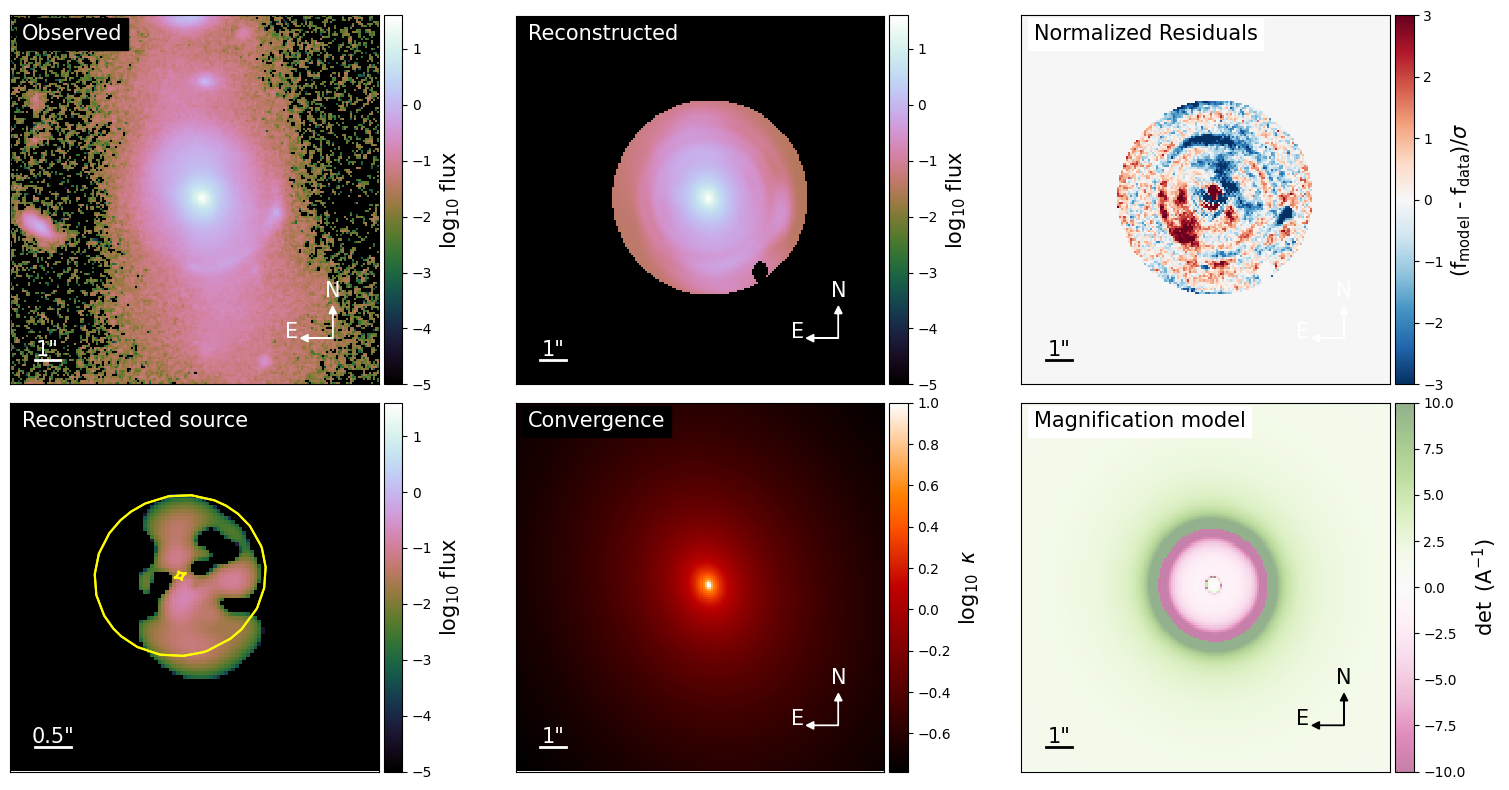

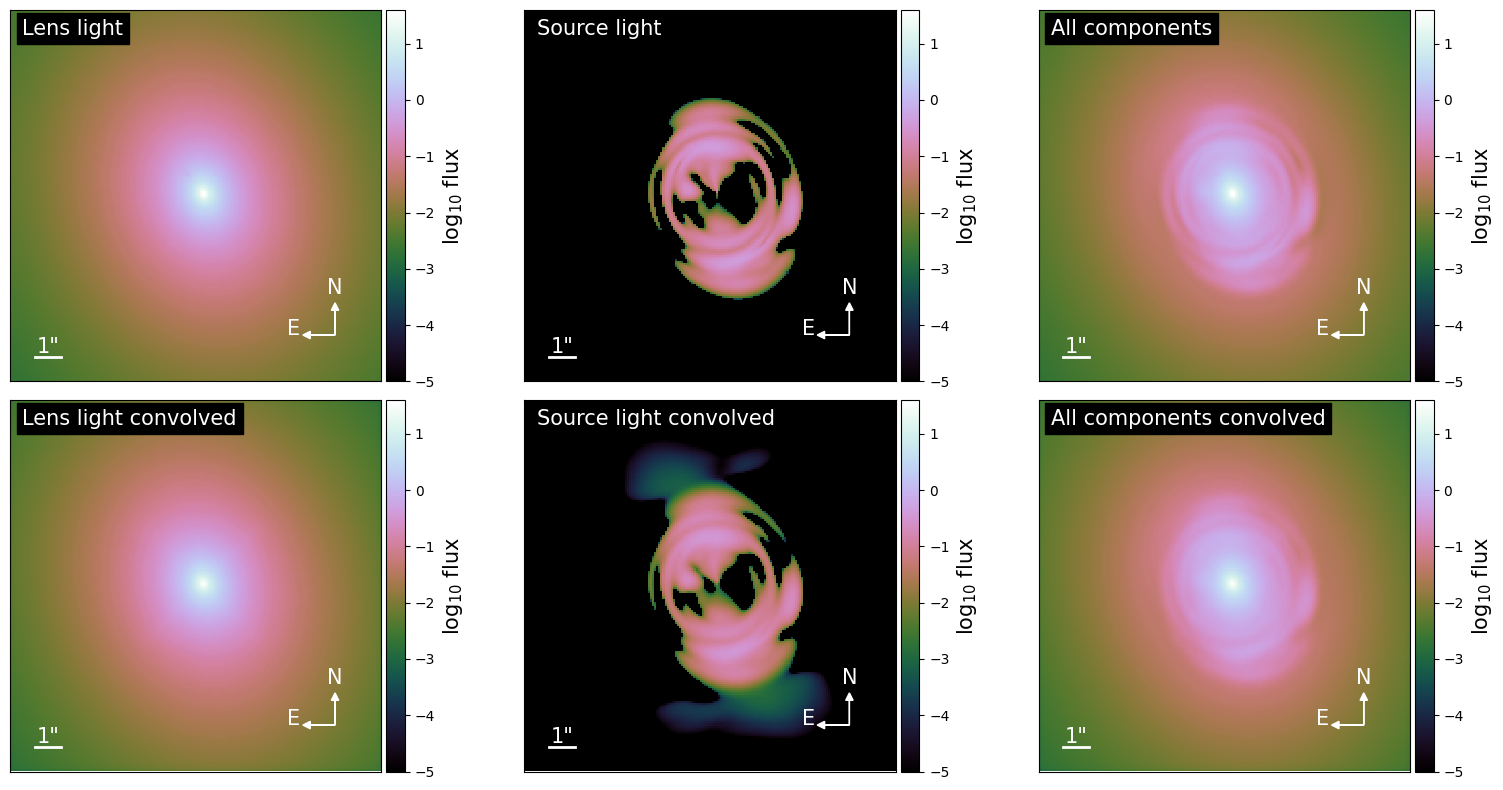

{'kwargs_lens': [{'theta_E': 2.158186808413816, 'gamma': 1.7916869774360928, 'e1': -0.08801346931946684, 'e2': 0.06447740503772757, 'center_x': -0.2249433780006856, 'center_y': -0.021383819113691842}, {'gamma1': -0.07781581961259795, 'gamma2': 0.05978981987557863, 'ra_0': -1.508734725566375, 'dec_0': -1.0043789364525657}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.4718550023088072, 'n_sersic': 1.0, 'e1': 0.10915391169116755, 'e2': -0.12874519899512085, 'center_x': -0.3762312519680732, 'center_y': -0.3313359570483421}, {'amp': 1, 'n_max': 8, 'beta': 0.25104627850680467, 'center_x': -0.3762312519680732, 'center_y': -0.3313359570483421}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.9829775202631845, 'n_sersic': 4.0, 'e1': -0.08801346931946684, 'e2': 0.06447740503772757, 'center_x': -0.2249433780006856, 'center_y': -0.021383819113691842}, {'amp': 1, 'R_sersic': 0.19675102056693028, 'n_sersic': 1.0, 'e1': 0.06801626806983974, 'e2': 0.23411666648479507, 'center_x': 0.3853423988497692, 'c

In [98]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(
    ax=axes[0, 2],
    v_min=-3,
    v_max=3,
    cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0],
    deltaPix_source=0.05,
    with_caustics=True,
    scale_size=0.5,
    numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0,
    hspace=0.05
)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0,
    hspace=0.05
)
plt.show()
print(kwargs_result)